<div style="direction:ltr;line-height:300%;">
	<font face="Arial" size=5>
		<div align=center>
				<p></p>
				<p></p>
In the Name of God
            <p></p>
<br>
            Sharif University of Technology
            <br>
Computer Engineering Department
            <p></p>
Artificial Intelligence Course
            <br />
			<br />
            MohammadHossein Rohban
            <br />
Fall 2021
        </div>
		<hr/>
			<div align=center>
Generative Adversarial Networks
        </div>
		<br />
		<div align=center>
Arman Zarei
        </div>
		<hr />
		<style type="text/css" scoped>
        p{
        border: 1px solid #a2a9b1;background-color: #f8f9fa;display: inline-block;
        };
        </style>
		<div>
			<h3>Table of Contents</h3>
			<ul style="margin-right: 0;">
				<li>
                    <a href="#sec_intro">
                        Introduction
                    </a>
                </li>
                <li>
					<a href="#sec_1">
                    Section 1
                    </a>
				</li>
                <li>
					<a href="#sec_2">
                Section 2
                    </a>
				</li>
			</ul>
		</div>
	</font>
</div>

<p></p>
<br />
<div id="sec_intro" style="direction:ltr;line-height:300%;">
	<font face="Arial" size=5>
		<font color=#888888 size=6>
Introduction
        </font>
		<p></p>
		<hr>
GANs are a framework for teaching a DL model to capture the training data’s distribution so we can generate new data from that same distribution. GANs were invented by Ian Goodfellow in 2014 and first described in the paper Generative Adversarial Nets. They are made of two distinct models, a <strong>generator</strong> and a <strong>discriminator</strong>.
<ul>
	<li>The job of the generator is to spawn ‘fake’ images that look like the training images.</li>
	<li>The job of the discriminator is to look at an image and output whether or not it is a real training image or a fake image from the generator.</li>
</ul>
   During training, 
	<ul>
		<li>the generator is constantly trying to outsmart the discriminator by generating better and better fakes,</li>
		<li>while the discriminator is working to become a better detective and correctly classify the real and fake images.</li>
	</ul>
     The equilibrium of this game is when the generator is generating perfect fakes that look as if they came directly from the training data, and the discriminator is left to always guess at 50% confidence that the generator output is real or fake.
        <br>
        <br/>
		<div style='text-align: center;'>
			<img src='./images/GAN.PNG'>
		</div>

<p></p>
<br />
<div id="sec_1" style="direction:ltr;line-height:300%;">
	<font face="Arial" size=5>
		<font color=#888888 size=6>
Theory of GAN
        </font>
		<p></p>
		<hr>

First, Lets define some notations:
- $x$: Data representing an image
- $D(x)$: The discriminator network which outputs the (scalar) probability that $x$ came from training data rather than the generator
    - $D(x)$ should be **high** when $x$ comes from training data
    - and **low** when $x$ comes from the generator.
- $z$: A latent space vector sampled from a standard normal distribution 
- $G(z)$: The generator function which maps the latent vector $z$ to data-space. 
    - goal of $G$: estimate the distribution that the training data comes from ($p_{data}$) so it can generate fake samples from that estimated distribution ($p_g$).

So, $D(G(z))$ is the probability (scalar) that the output of the generator GG is a real image. As described in Goodfellow’s paper, $D$ and $G$ play a minimax game in which DD tries to maximize the probability it correctly classifies reals and fakes ($logD(x)$), and $G$ tries to minimize the probability that $D$ will predict its outputs are fake ($log(1-D(G(z)))$).  From the paper, the GAN loss function is:
$$
\min_{G}\max_{D}V(D, G) = \mathbb{E}_{x \sim p_{data}(x)} [logD(x)] + \mathbb{E}_{z \sim p_{z}(z)} [log(1 - D(G(z)))]
$$
In theory, the solution to this minimax game is where $p_g=p_{data}$, and the discriminator guesses randomly if the inputs are real or fake. However, the convergence theory of GANs is still being actively researched and in reality models do not always train to this point.


Many variations of GANs were introduced which may have changed the loss function or etc. but the main idea of generator and disriminator remains still. In the next section we're going to see a version of it.

<p></p>
<br />
<div id="sec_2" style="direction:ltr;line-height:300%;">
	<font face="Arial" size=5>
		<font color=#888888 size=6>
Implementation of WGAN-GP in PyTorch
        </font>
		<p></p>
		<hr>
		

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision
import matplotlib.pyplot as plt

C:\Users\Arman_PC\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, features_g * 16, 4, 1, 0), 
            self._block(features_g * 16, features_g * 8, 4, 2, 1), 
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [3]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    
    return gradient_penalty

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 20
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

In [5]:
transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)
dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [6]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

In [7]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

In [8]:
gen.train()
critic.train()

for epoch in tqdm(range(NUM_EPOCHS)):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

torch.save(gen.state_dict(), 'checkpoints/wgan-gp_gen.pth')
torch.save(critic.state_dict(), 'checkpoints/wgan-gp_critic.pth')

100%|██████████| 20/20 [1:06:42<00:00, 200.14s/it]


In [9]:
gen.load_state_dict(torch.load('checkpoints/wgan-gp_gen.pth'))
critic.load_state_dict(torch.load('checkpoints/wgan-gp_critic.pth'));

Generating random numbers

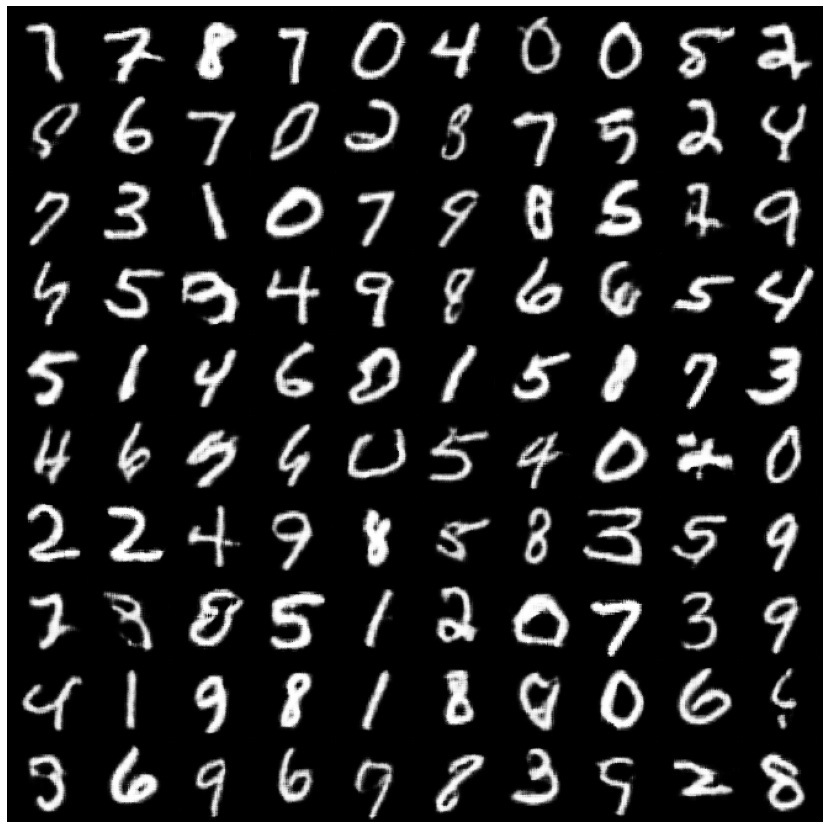

In [10]:
z = torch.randn(100, Z_DIM, 1, 1).to(device)
gen_imgs = gen(z)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(gen_imgs, normalize=True, nrow=10).cpu().permute(1, 2, 0));

<p></p>
<br />
<div id="sec_2" style="direction:ltr;line-height:300%;">
	<font face="Arial" size=5>
		<font color=#888888 size=6>
Conditional GAN
        </font>
		<p></p>
		<hr>
        The conditional generative adversarial network, or cGAN for short, is a type of GAN that involves the conditional generation of images by a generator model. Image generation can be conditional on a class label, if available, allowing the targeted generated of images of a given type.
        <ul>
            <li>
                For example, imagine the MNIST dataset and suppose we want to generate samples of numbers, but, we want to control which number to generate.
            </li>
        </ul>
        Here is a comparison of GANs and cGANs:
        <br>
        <div style="text-align: center;">
            <img src='https://learnopencv.com/wp-content/uploads/2021/07/Conditional-GAN-in-PyTorch-and-TensorFlow.jpeg'>
        </div>
		

<p></p>
<br />
<div id="sec_2" style="direction:ltr;line-height:300%;">
	<font face="Arial" size=5>
		<font color=#888888 size=6>
Implementation of Conditional WGAN-GP in PyTorch
        </font>
		<p></p>
		<hr>


In [11]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img+1, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim=1)
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes, embed_size):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channels_noise+embed_size, features_g * 16, 4, 1, 0), 
            self._block(features_g * 16, features_g * 8, 4, 2, 1), 
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3) 
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)

In [12]:
def gradient_penalty(critic, labels, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    mixed_scores = critic(interpolated_images, labels)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    
    return gradient_penalty

In [13]:
NUM_CLASSES = 10
GEN_EMBEDDING = 100

In [14]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, GEN_EMBEDDING).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES, IMAGE_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

In [15]:
gen.train()
critic.train()

for epoch in tqdm(range(NUM_EPOCHS)):
    for batch_idx, (real, labels) in enumerate(loader):
        real, labels = real.to(device), labels.to(device)
        cur_batch_size = real.shape[0]

        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise, labels)
            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)
            gp = gradient_penalty(critic, labels, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        gen_fake = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

torch.save(gen.state_dict(), 'checkpoints/cwgan-gp_gen.pth')
torch.save(critic.state_dict(), 'checkpoints/cwgan-gp_critic.pth')

100%|██████████| 20/20 [1:11:39<00:00, 214.95s/it]


In [16]:
gen.load_state_dict(torch.load('checkpoints/cwgan-gp_gen.pth'))
critic.load_state_dict(torch.load('checkpoints/cwgan-gp_critic.pth'));

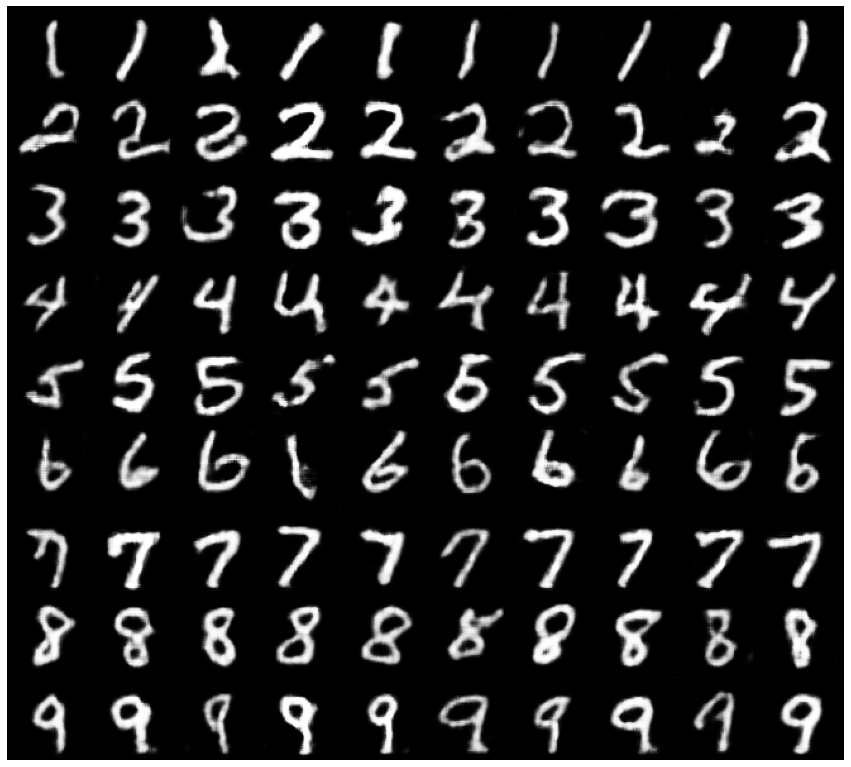

In [17]:
z = torch.randn(90, Z_DIM, 1, 1).to(device)
labels = torch.arange(1, 10).repeat_interleave(10).to(device)
gen_imgs = gen(z, labels)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(gen_imgs, normalize=True, nrow=10).cpu().permute(1, 2, 0));

<p></p>
<br />
<div id="sec_2" style="direction:ltr;line-height:300%;">
	<font face="Arial" size=5>
		<font color=#888888 size=6>
Other types of GAN
        </font>
		<p></p>
		<hr>

You can read about different types of GAN from [here](https://www.youtube.com/playlist?list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va). In these series of videos you will learn about:
- Simple GAN
- DCGAN
- WGAN
- WGAN-GP
- Pix2Pix
- CycleGAN
- ProGAN
- SRGAN
- ...

<p></p>
<br/>
<div id="sec_refs" style="direction:ltr;line-height:300%;">
	<font face="Arial" size=5>
		<font color=#888888 size=6>
References
        </font>
		<hr>
	</font>
</div>

- [A Gentle Introduction to Generative Adversarial Networks (GANs)](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)
- [How to Develop a Conditional GAN (cGAN) From Scratch](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/)
- [Generative Adversarial Networks (GANs) Playlist](https://www.youtube.com/playlist?list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va)
- [WGAN implementation from scratch (with gradient penalty)](https://www.youtube.com/watch?v=pG0QZ7OddX4&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=5)
- [Pytorch Conditional GAN Tutorial](https://www.youtube.com/watch?v=Hp-jWm2SzR8&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=6)
- [Github Source for Implementations of GANs](https://github.com/aladdinpersson/Machine-Learning-Collection)
- [WGAN-GP Pytorch](https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/4.%20WGAN-GP)